### Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_ROOT = "/content/drive/MyDrive/cs284/"

### Explore Data of Each Classes

## Mask RCNN

In [3]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ppajpzct
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ppajpzct
  Resolved https://github.com/facebookresearch/detectron2.git to commit a0e22dbfa791e6235e4f196d5ce25e754d02be31
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6118745 sha256=2a9795f3fae08e506795155aaf2eb

In [4]:
import os
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

test_data_path = os.path.join(DATA_ROOT, "archive/Dataset_BUSI_with_GT/test")
test_json_path = os.path.join(DATA_ROOT, "archive/Dataset_BUSI_with_GT/coco.json")

register_coco_instances("test_BUSI", {}, test_json_path, test_data_path)

In [8]:
# Configuration setup
from detectron2.data import transforms as T
cfg = get_cfg()

# Select model and load pretrained weights
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Set dataset-specific parameters
cfg.DATASETS.TRAIN = ("BUSI_train",)
cfg.DATASETS.TEST = ("BUSI_val",)
cfg.DATALOADER.NUM_WORKERS = 8

# Set training hyperparameters
cfg.INPUT.AUGMENTATIONS = [
    T.ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice'),
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    T.RandomBrightness(0.8, 1.2),
    T.RandomContrast(0.8, 1.2),
    T.RandomSaturation(0.8, 1.2)
]
cfg.SOLVER.IMS_PER_BATCH = 2  #
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.WEIGHT_DECAY = 0.0001  # L2 regularization
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.OUTPUT_DIR = os.path.join(DATA_ROOT, "Models")

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

### Evaluation

In [9]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "mask_rcnn_model.pth")  # Path to the model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(cfg)


In [10]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

os.makedirs(os.path.join(cfg.OUTPUT_DIR, "test"), exist_ok=True)
evaluator = COCOEvaluator("test_BUSI", cfg, False, output_dir=os.path.join(cfg.OUTPUT_DIR, "test"))
val_loader = build_detection_test_loader(cfg, "test_BUSI")
inference_on_dataset(predictor.model, val_loader, evaluator)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox',
              {'AP': 11.516470830862156,
               'AP50': 30.999401866691993,
               'AP75': 3.7906843232893084,
               'APs': 0.0,
               'APm': 9.530726526348912,
               'APl': 14.473393141586243,
               'AP-normal': nan,
               'AP-benign': 20.97023539109725,
               'AP-malignant': 2.0627062706270625}),
             ('segm',
              {'AP': 12.99888465030411,
               'AP50': 27.809513761841032,
               'AP75': 7.561936057084166,
               'APs': 0.0,
               'APm': 10.903662314928114,
               'APl': 16.36342110694973,
               'AP-normal': nan,
               'AP-benign': 24.430112534931652,
               'AP-malignant': 1.5676567656765676})])

In [11]:
import os
import random
import cv2

test_image_dir = os.path.join(DATA_ROOT, "archive/Dataset_BUSI_with_GT/test")  # Update with your test image directory
test_images = os.listdir(test_image_dir)
selected_images = random.sample(test_images, 3)  # Select 3 random images for visualization

predictions = []
for img_name in selected_images:
    img_path = os.path.join(test_image_dir, img_name)
    img = cv2.imread(img_path)
    outputs = predictor(img)
    predictions.append((img, outputs))

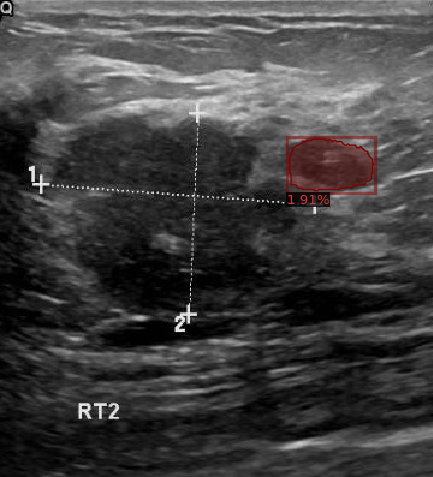

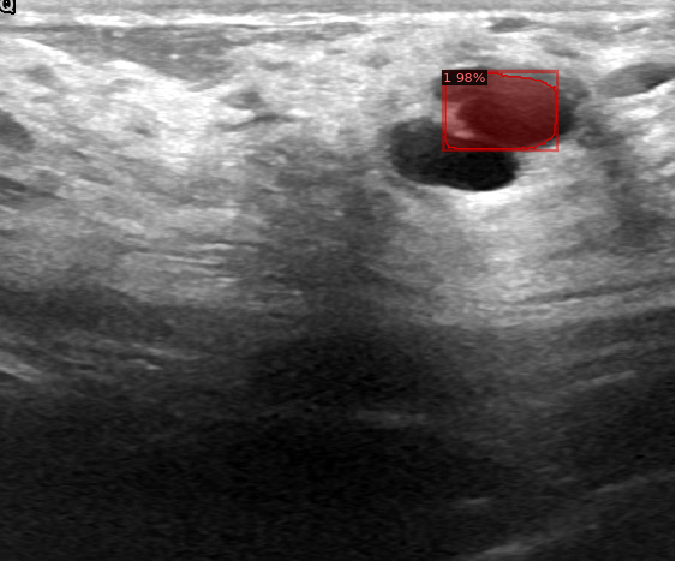

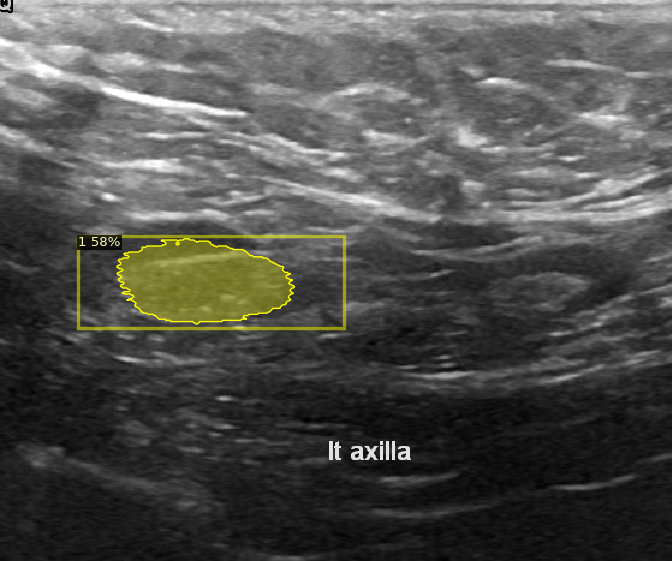

In [12]:
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

for img, output in predictions:
    # Create a visualizer instance
    instances = output["instances"].to("cpu")

    if len(instances) > 0:
        # Filter to keep only the instance with the highest score
        max_score_index = instances.scores.argmax().item()

        top_instance = instances[max_score_index]

        v = Visualizer(img[:, :, ::-1],
                      metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                      scale=1.2,
                      instance_mode=ColorMode.IMAGE_BW)

        # Visualize the predictions
        v = v.draw_instance_predictions(top_instance)
        visualized_img = v.get_image()[:, :, ::-1]

    # Display the image
    cv2_imshow(visualized_img)
    cv2.waitKey(0)


## Faster RCNN

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

# Configuration setup
faster_cfg = get_cfg()

# Select model and load pretrained weights for Faster R-CNN
faster_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# faster_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# Set dataset-specific parameters
faster_cfg.DATASETS.TRAIN = ("BUSI_train",)
faster_cfg.DATASETS.TEST = ("BUSI_val",)
faster_cfg.DATALOADER.NUM_WORKERS = 8

# Set training hyperparameters (same as before)
faster_cfg.INPUT.AUGMENTATIONS = [
    T.ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice'),
    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    T.RandomBrightness(0.8, 1.2),
    T.RandomContrast(0.8, 1.2),
    T.RandomSaturation(0.8, 1.2)
]
faster_cfg.SOLVER.IMS_PER_BATCH = 2
faster_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # Set the number of classes
faster_cfg.SOLVER.BASE_LR = 0.00025
faster_cfg.SOLVER.WEIGHT_DECAY = 0.0001
faster_cfg.SOLVER.MAX_ITER = 1000
faster_cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
faster_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
faster_cfg.OUTPUT_DIR = os.path.join(DATA_ROOT, "Models")

os.makedirs(faster_cfg.OUTPUT_DIR, exist_ok=True)

### Evaluation

In [14]:
from detectron2.engine import DefaultPredictor

faster_cfg.MODEL.WEIGHTS = os.path.join(faster_cfg.OUTPUT_DIR, "faster_rcnn_model.pth")  # Path to the model weights
faster_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for this model
predictor = DefaultPredictor(faster_cfg)

In [16]:
os.makedirs(os.path.join(faster_cfg.OUTPUT_DIR, "test"), exist_ok=True)
evaluator = COCOEvaluator("test_BUSI", faster_cfg, False, output_dir=os.path.join(faster_cfg.OUTPUT_DIR, "test"))
val_loader = build_detection_test_loader(faster_cfg, "test_BUSI")
inference_on_dataset(predictor.model, val_loader, evaluator)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.

OrderedDict([('bbox',
              {'AP': 9.152385569528514,
               'AP50': 30.917345354251115,
               'AP75': 2.2320653117943374,
               'APs': 0.0,
               'APm': 6.752903313566702,
               'APl': 9.628106968310838,
               'AP-normal': nan,
               'AP-benign': 11.26127733866517,
               'AP-malignant': 7.043493800391859})])

In [17]:
test_image_dir = os.path.join(DATA_ROOT, "archive/Dataset_BUSI_with_GT/test")  # Update with your test image directory
test_images = os.listdir(test_image_dir)
selected_images = random.sample(test_images, 3)  # Select 3 random images for visualization

predictions = []
for img_name in selected_images:
    img_path = os.path.join(test_image_dir, img_name)
    img = cv2.imread(img_path)
    outputs = predictor(img)
    predictions.append((img, outputs))

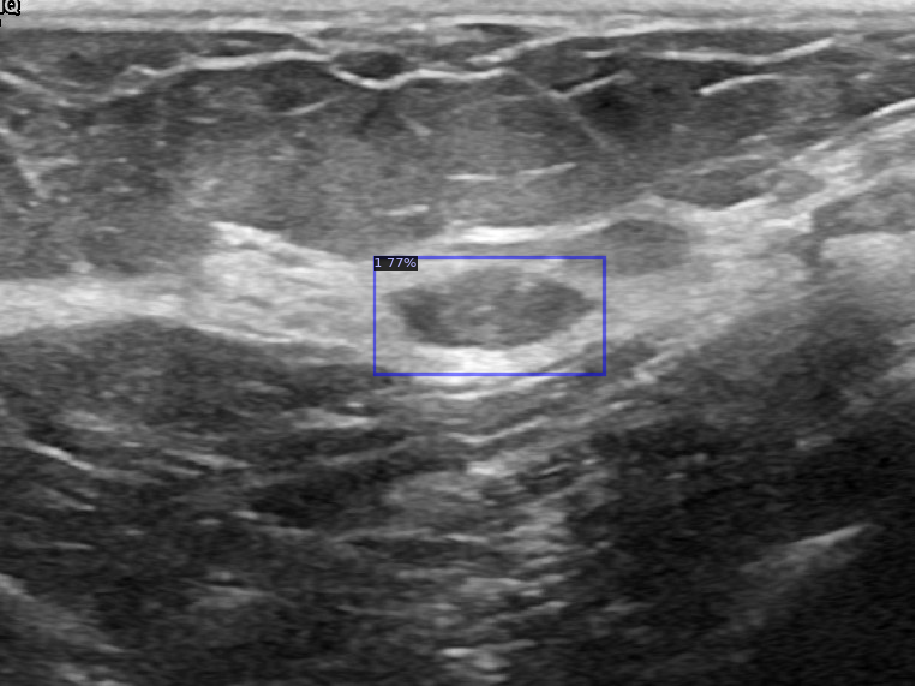

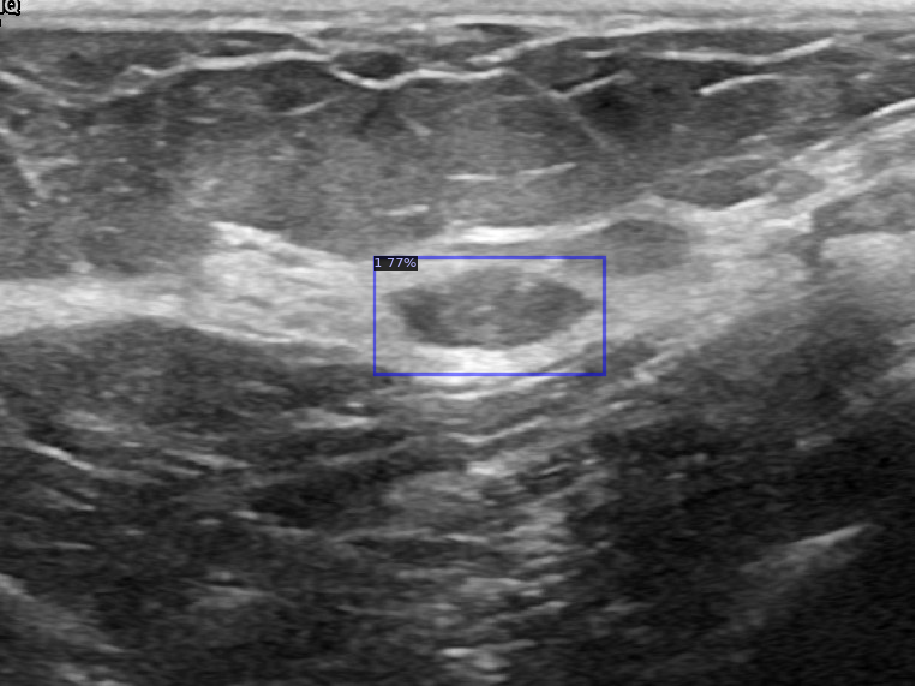

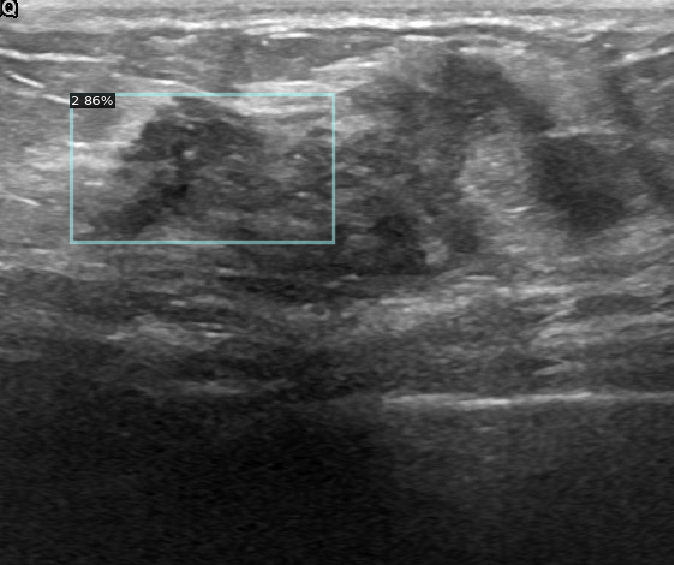

In [18]:
for img, output in predictions:
    # Create a visualizer instance
    instances = output["instances"].to("cpu")
    if len(instances) > 0:
        # Filter to keep only the instance with the highest score
        max_score_index = instances.scores.argmax().item()

        top_instance = instances[max_score_index]

        v = Visualizer(img[:, :, ::-1],
                      metadata=MetadataCatalog.get(faster_cfg.DATASETS.TRAIN[0]),
                      scale=1.2,
                      instance_mode=ColorMode.IMAGE_BW)

        # Visualize the predictions
        v = v.draw_instance_predictions(top_instance)
        visualized_img = v.get_image()[:, :, ::-1]

    # Display the image
    cv2_imshow(visualized_img)
    cv2.waitKey(0)

## UNet

In [19]:
import torch

if torch.cuda.is_available():
    print("CUDA(GPU) available")
    device = torch.device("cuda")
else:
    print("CUDA(GPU) unavailable. CPU used.")
    device = torch.device("cpu")

CUDA(GPU) available


In [24]:
import numpy as np
test_data =  np.load(os.path.join(DATA_ROOT, 'archive/test_data.npz'))

In [25]:
# get the image, mask and labels
X_test, masks_test, y_test = test_data['images'], test_data['masks'], test_data['labels']

In [22]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [26]:
import os

checkpoint_path = os.path.join(DATA_ROOT, 'Models/unet_model_epoch_5.pth')
if os.path.exists(checkpoint_path):
    torch.load(checkpoint_path)
    print(f"'{checkpoint_path}' loaded")

In [27]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Dropout(0.3)
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                    torch.nn.Dropout(0.3)
                    )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.Sigmoid()
                    )
            return  block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encoder
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
                            torch.nn.Dropout(0.3)
                            )
        # Decoder
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [28]:
unet = UNet(in_channel=1,out_channel=1)
optimizer = torch.optim.Adam(unet.parameters(), lr = 0.01)
criterion = torch.nn.BCELoss()

In [29]:
# convert numpy array to tensor
X_test = torch.from_numpy(X_test).float()

masks_test = torch.from_numpy(masks_test).float()

X_test = X_test.permute(0, 3, 1, 2)

masks_test = masks_test.permute(0, 3, 1, 2)


In [30]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8

# combine X_train and masks_train to randomly load batch size amount of the data
test_dataset = TensorDataset(X_test, masks_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)

In [32]:
def IoU(outputs, masks):
    intersection = torch.logical_and(outputs, masks).sum()
    union = torch.logical_or(outputs, masks).sum()
    iou = intersection.float() / union.float()
    return iou.item()

In [33]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, early_stopping_patience):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.log_interval = 8

        self.train_losses = []
        self.val_losses = []
        self.train_iou = []
        self.val_iou = []

        self.best_model = None
        self.best_iou = 0.0
        self.best_epoch = 0

        self.early_stopping_patience = early_stopping_patience
        self.epochs_no_improve = 0

    def save_best_model(self, epoch, iou):
        if iou > self.best_iou:
            self.best_iou = iou
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = 'unet_model_best.pth'
            torch.save(self.best_model, filename)

    def train(self, train_dataloader, val_dataloader):

        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_iou = 0.0
            val_iou = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_dataloader):

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                masks_resized = F.interpolate(masks, size=(412, 412), mode='nearest')
                loss = self.criterion(outputs, masks_resized)
                iou = IoU(outputs, masks_resized)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_iou += iou

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}, IoU: {iou:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_dataloader:
                    outputs = self.model(images)
                    masks_resized = F.interpolate(masks, size=(412, 412), mode='nearest')
                    val_loss += self.criterion(outputs, masks_resized).item()
                    val_iou += IoU(outputs, masks_resized)

            avg_train_loss = train_loss / len(train_dataloader)
            avg_val_loss = val_loss / len(val_dataloader)
            avg_train_iou = train_iou / len(train_dataloader)
            avg_val_iou = val_iou / len(val_dataloader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train IoU: {avg_train_iou:.4f}, Val IoU: {avg_val_iou:.4f}')

            # save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_iou.append(avg_train_iou)
            self.val_iou.append(avg_val_iou)

            # save the latest model
            checkpoint = {"state_dict": self.model.state_dict(),
                          "optimizer": self.optimizer.state_dict(),
                          "epoch": epoch,
                          "train_losses": self.train_losses,
                          "train_iou": self.train_iou,
                          "best_iou": self.best_iou,
                          "best_model": self.best_model,
                          "best_epoch": self.best_epoch,
                          "epochs_no_improve": self.epochs_no_improve,
                          "val_losses": self.val_losses,
                          "val_iou": self.val_iou}
            torch.save(checkpoint, f"unet_model_epoch_{epoch+1}")

            # save best model
            self.save_best_model(epoch+1, avg_val_iou)

            # early stopping
            if avg_val_iou <= self.best_iou:
                self.epochs_no_improve += 1
                if self.epochs_no_improve == self.early_stopping_patience:
                    print(f"early stopping: no improvement on epoch {epoch + 1}")
                    break
            else:
                self.epochs_no_improve = 0

    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_iou': self.train_iou,
            'val_iou': self.val_iou,
            'best_epoch': self.best_epoch,
            'best_iou': self.best_iou
        }

In [34]:
trainer = Trainer(model=unet, num_epochs=10, optimizer=optimizer, criterion=criterion, early_stopping_patience=5)

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import torch
import numpy as np

unet = unet.to(device)
unet.eval()

y_true, y_scores = [], []
test_loss = 0.00
test_iou = 0.00

with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = unet(images)
        masks_resized = F.interpolate(masks, size=(412, 412), mode='nearest')
        masks_resized_binary = masks_resized > 0.5

        y_true.append(masks_resized_binary.cpu().numpy().flatten())
        y_scores.append(outputs.cpu().numpy().flatten())

        test_loss += criterion(outputs, masks_resized).item()
        test_iou += IoU(outputs, masks_resized)

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

ap = average_precision_score(y_true, y_scores)

avg_test_loss = test_loss / len(test_dataloader)
avg_test_iou = test_iou / len(test_dataloader)

print('Average Precision on Test Data:', ap)
print('Average BCE Loss on Test Data:', avg_test_loss)
print('Average IoU on Test Data:', avg_test_iou)

Average Precision on Test Data: 0.10144194577686487
Average BCE Loss on Test Data: 0.693401449918747
Average IoU on Test Data: 0.09249254241585732


In [36]:
import matplotlib.pyplot as plt

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def plot_subplots(image, mask, predicted):
    # Convert tensors to NumPy arrays
    image_np = to_numpy(image)
    image_np = image_np.squeeze()
    mask_np = to_numpy(mask)
    mask_np = mask_np.squeeze()
    predicted_np = to_numpy(predicted)

    fig, axes = plt.subplots(1, 3, figsize=(5, 3))

    # Plot Image
    axes[0].imshow(image_np)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Plot Mask
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    # Plot Predicted
    axes[2].imshow(predicted_np, cmap='gray')
    axes[2].set_title('Predicted')
    axes[2].axis('off')

    plt.show()

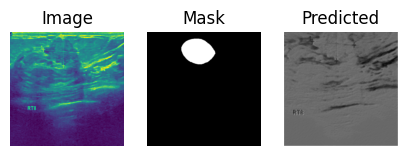

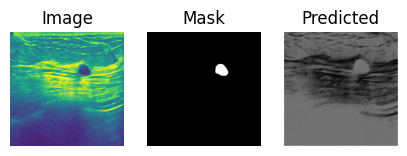

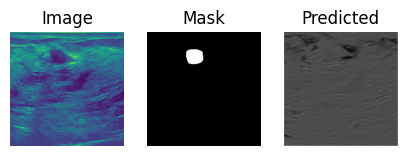

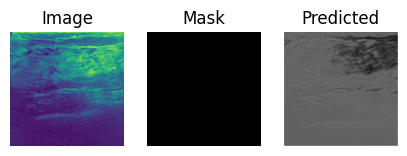

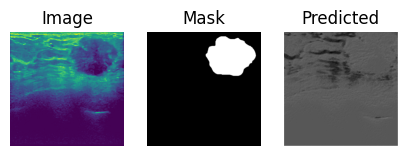

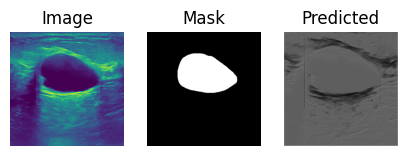

In [37]:
unet.eval()
unet.to(device)

for i in [3, 12, 48, 51, 66, 77]:
    image = test_dataset[i][0]
    mask = test_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

## MedSAM

In [38]:
!pip install git+https://github.com/bowang-lab/MedSAM.git

  Cloning https://github.com/bowang-lab/MedSAM.git to /tmp/pip-req-build-p9tu18o2
  Running command git clone --filter=blob:none --quiet https://github.com/bowang-lab/MedSAM.git /tmp/pip-req-build-p9tu18o2
  Resolved https://github.com/bowang-lab/MedSAM.git to commit 861d42440061c704762a9bb9a574e7c31d8d751a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.2 MB/s eta 0:00:00
    

In [39]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt



device = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
checkpoint_path = os.path.join(DATA_ROOT, 'Models/best_model_sam.pth')
finetuned_model = sam_model_registry['vit_b'](checkpoint=checkpoint_path)
finetuned_model = finetuned_model.to(device)
finetuned_model.eval

<bound method Module.eval of Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [41]:
class MedSAM(nn.Module):
    def __init__(
        self,
        image_encoder,
        mask_decoder,
        prompt_encoder,
    ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder
        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False

    def forward(self, image, box):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)
        # do not compute gradients for prompt encoder
        with torch.no_grad():
            box_torch = torch.as_tensor(box, dtype=torch.float32, device=image.device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :]  # (B, 1, 4)

            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        low_res_masks, _ = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )
        ori_res_masks = F.interpolate(
            low_res_masks,
            size=(image.shape[2], image.shape[3]),
            mode="bilinear",
            align_corners=False,
        )
        return ori_res_masks

In [42]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

def get_bounding_box(mask):
    # Find the non-zero indices in the mask
    non_zero_indices = np.where(mask)

    if len(non_zero_indices[0]) == 0:
        # Return a placeholder value for an empty mask
        return np.zeros((1, 4))

    # Compute the bounding box coordinates
    min_y, min_x = np.min(non_zero_indices, axis=1)
    max_y, max_x = np.max(non_zero_indices, axis=1)

    # Return the bounding box coordinates as a 2D array
    return np.array([[min_x, min_y, max_x, max_y]])


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [43]:
test_data=np.load(os.path.join(DATA_ROOT, 'archive/test_data.npz'))
X_test, masks_test, y_test = test_data['images'][0], test_data['masks'][0], test_data['labels'][0]


In [44]:
H, W = 500, 500
mask = np.squeeze(masks_test, axis=-1)
test_bbox = get_bounding_box(mask)
test_bbox = test_bbox / np.array([W, H, W, H]) * 1024
test_bbox_plot=test_bbox.squeeze()

In [45]:
img=np.repeat(X_test,3,axis=-1)
img_1024 = transform.resize(img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

In [46]:
with torch.no_grad():
  image_embedding = finetuned_model.image_encoder(img_1024_tensor)
  medsam_seg = medsam_inference(finetuned_model, image_embedding, test_bbox, 1024, 1024)

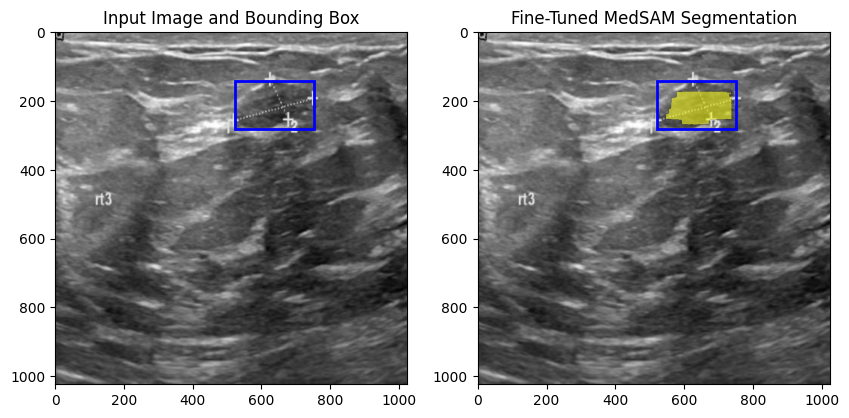

In [47]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_1024)
show_box(test_bbox_plot, ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_1024)
show_mask(medsam_seg, ax[1])
show_box(test_bbox_plot, ax[1])
ax[1].set_title("Fine-Tuned MedSAM Segmentation")
plt.show()